In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [5]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1979-01-01,266.876456,262.174096,264.777866,269.150430,271.769309,0.405713,0.012043,0.260519,0.542118,0.878378,...,0.000124,0.007968,0.365783,2.677222,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,263.137615,250.450487,261.616859,266.920908,267.913554,0.246617,-0.044947,0.100950,0.330685,0.734105,...,0.042746,0.349676,1.936703,3.059390,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,265.069197,253.009861,263.964245,268.177410,269.796373,0.024349,-0.117635,-0.058345,0.075822,0.294261,...,0.005359,0.141345,0.974921,2.130810,0.547433,0.0,0.0,1.00,2.00,NaN
1979-01-04,267.344933,256.471458,266.621912,269.692050,272.775006,0.272263,0.022934,0.107126,0.372084,0.793722,...,0.053330,2.054227,9.245433,16.898361,6.553525,0.0,3.0,9.00,17.00,NaN
1979-01-05,268.338573,258.071150,267.076994,271.385293,273.578574,0.092042,-0.108087,-0.037232,0.130155,0.562209,...,0.005481,0.092746,2.799600,5.075254,8.071802,0.0,3.0,12.00,20.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,275.762241,267.536506,274.311155,278.465387,279.337619,0.254065,-0.038233,0.087876,0.416218,0.529454,...,5.230701,9.182392,15.391766,21.072769,33.891645,0.0,0.0,38.00,186.00,1450.0
2017-12-28,271.553773,262.941584,270.339651,274.039722,274.848339,0.205865,-0.075538,0.055236,0.286332,0.723081,...,0.131408,0.539701,4.942257,8.836821,36.383812,0.0,0.0,43.75,192.00,1490.0
2017-12-29,270.972396,259.937912,269.350080,274.155302,274.844749,0.121224,-0.138864,0.027952,0.223373,0.335607,...,0.696965,3.463364,6.503335,9.478786,39.389034,0.0,0.0,48.75,199.00,1500.0
2017-12-30,278.579039,269.982895,276.958260,281.542313,282.258324,0.221681,0.018320,0.120946,0.304946,0.481947,...,7.546727,15.194395,27.565896,37.995136,37.480853,0.0,0.0,38.00,222.30,1670.0


In [6]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2, 0, 10)
epsilon_range=np.logspace(-3, -1, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=0.5994842503189409
eps=0.1


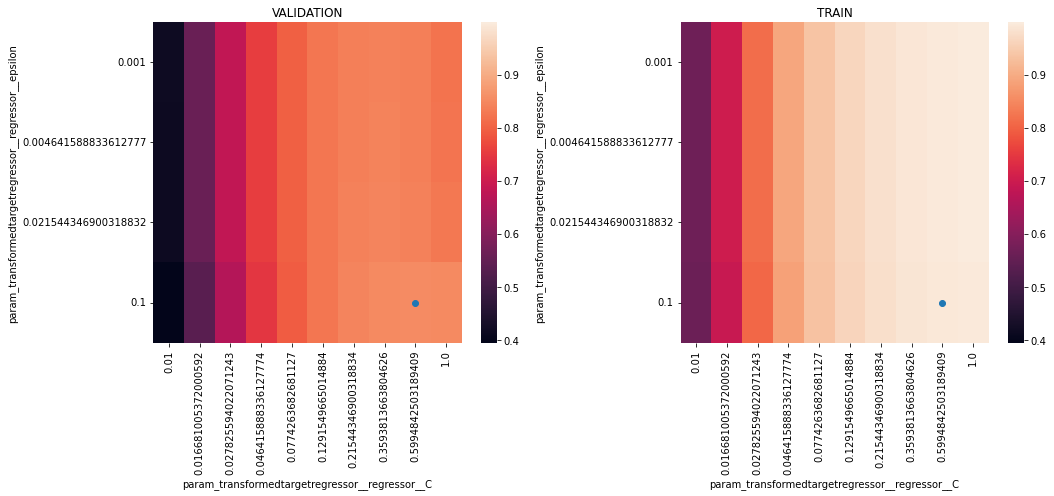

In [8]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [6]:
C_range=np.logspace(-1.5, 0.5, 10)
epsilon_range=np.logspace(-2.2, -0.2, 4)

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=0.6812920690579611
eps=0.13593563908785247


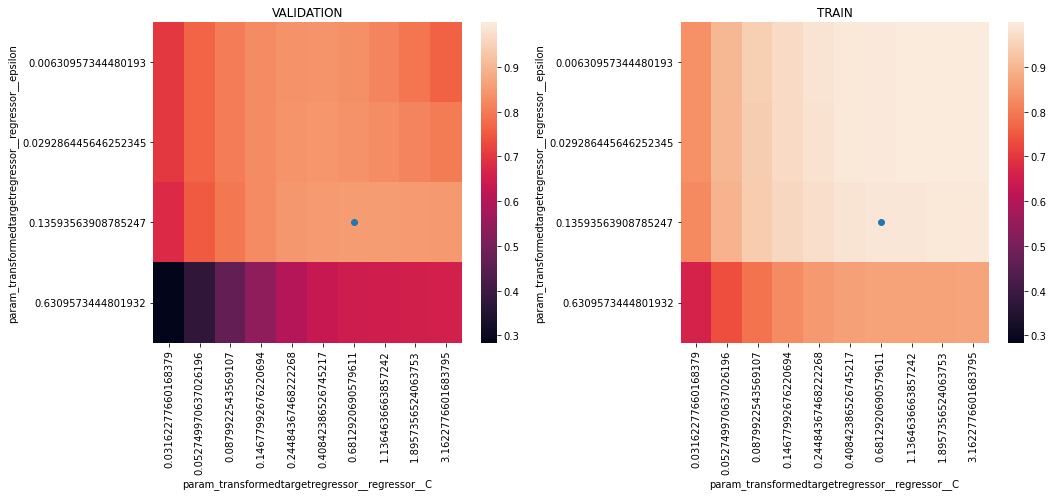

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [7]:
C=0.6812920690579611
eps=0.13593563908785247

In [8]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

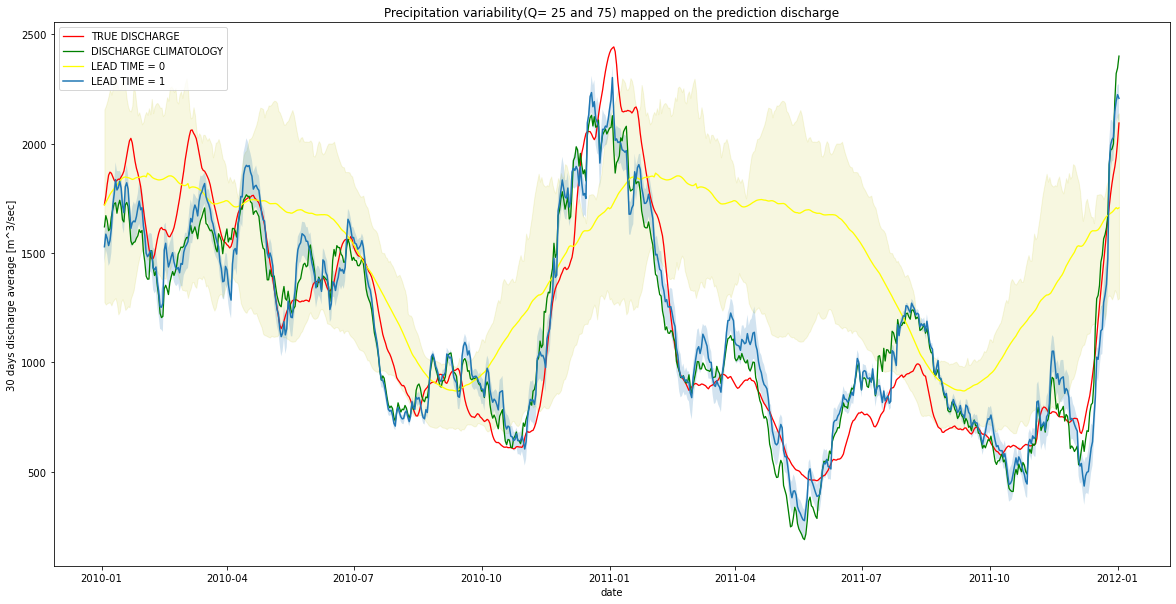

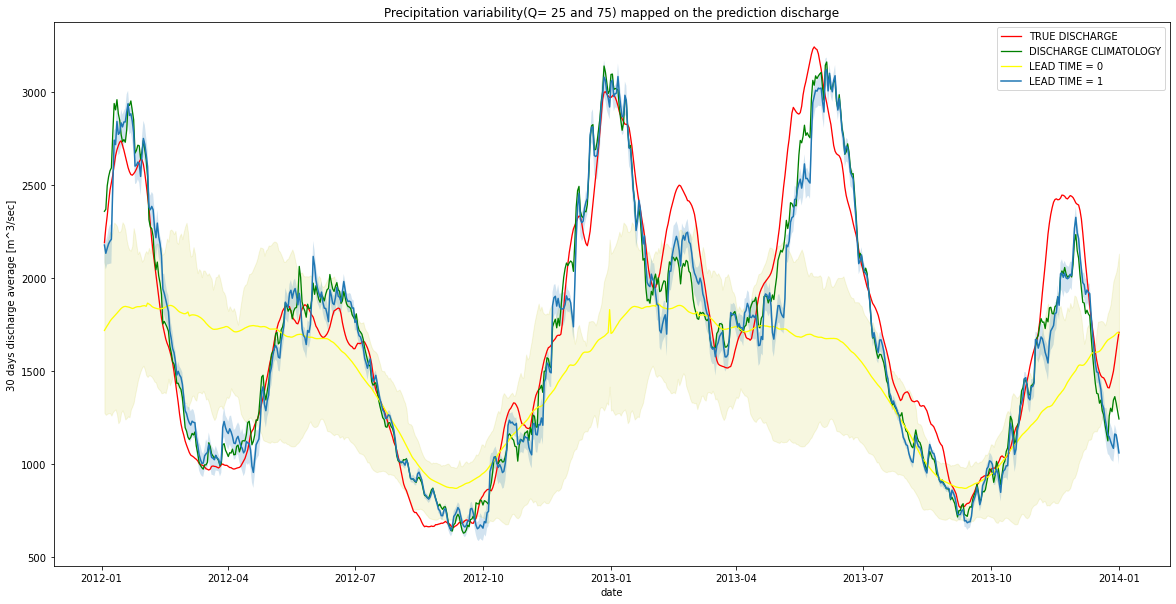

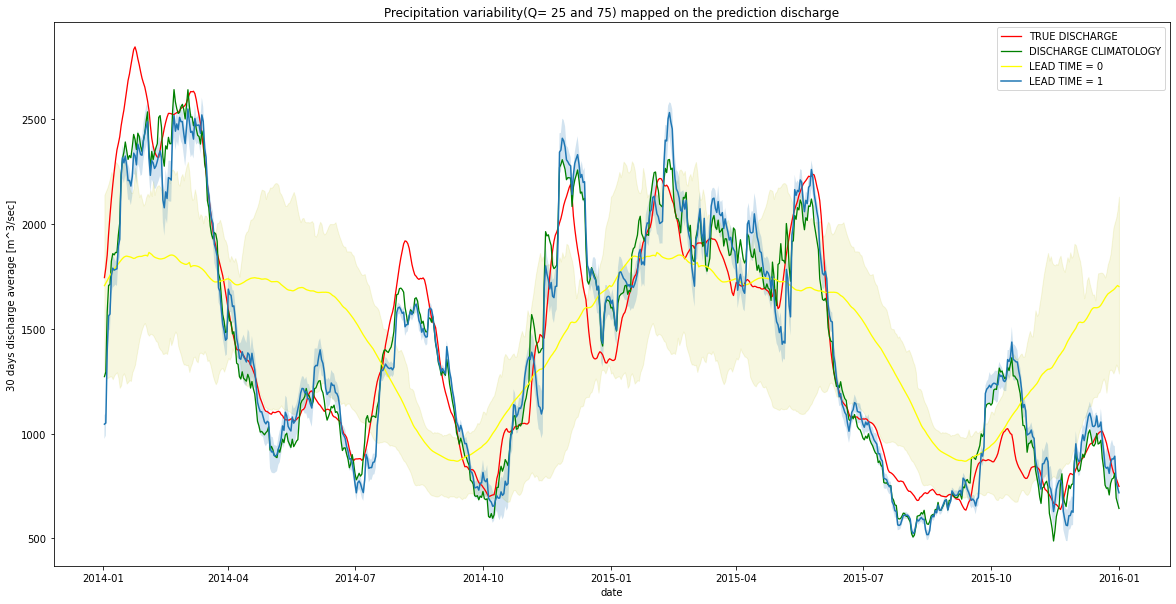

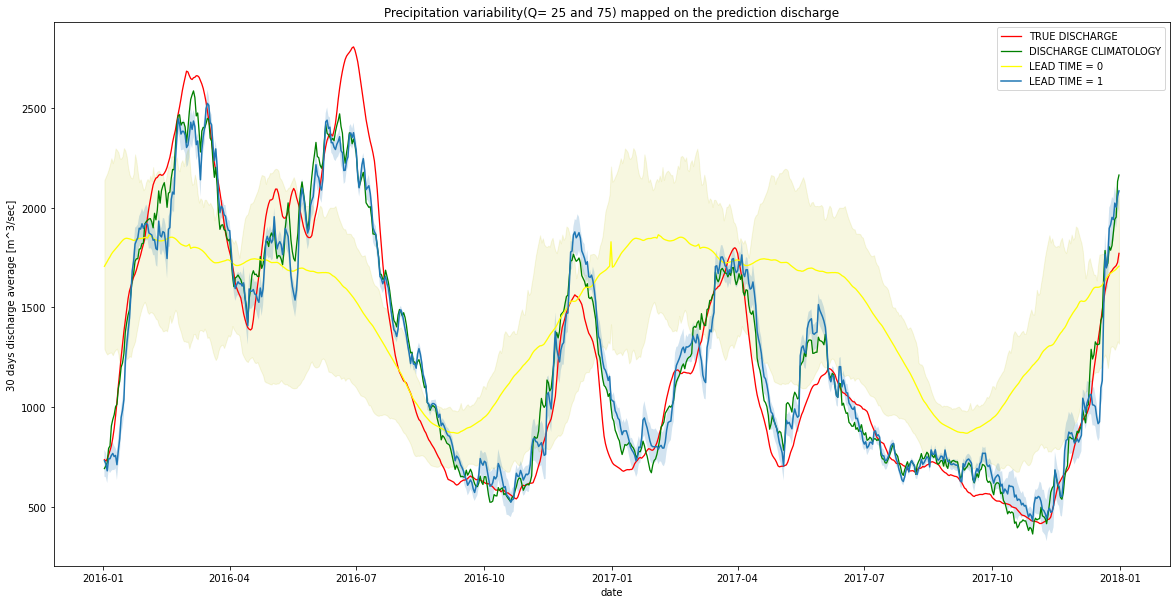

In [9]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


In [10]:
from test import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

measured runoff             1.000000
runoff climatology          0.287352
model output                0.885088
output 1 month lead time    0.848040
output 2 month lead time    0.716644
output 3 month lead time    0.501077
output 4 month lead time    0.344617
output 5 month lead time    0.225608
dtype: float64

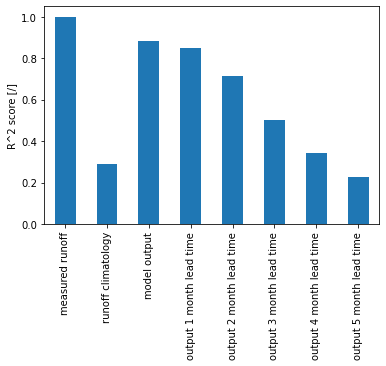

In [10]:
evaluate_prediction(predictions)

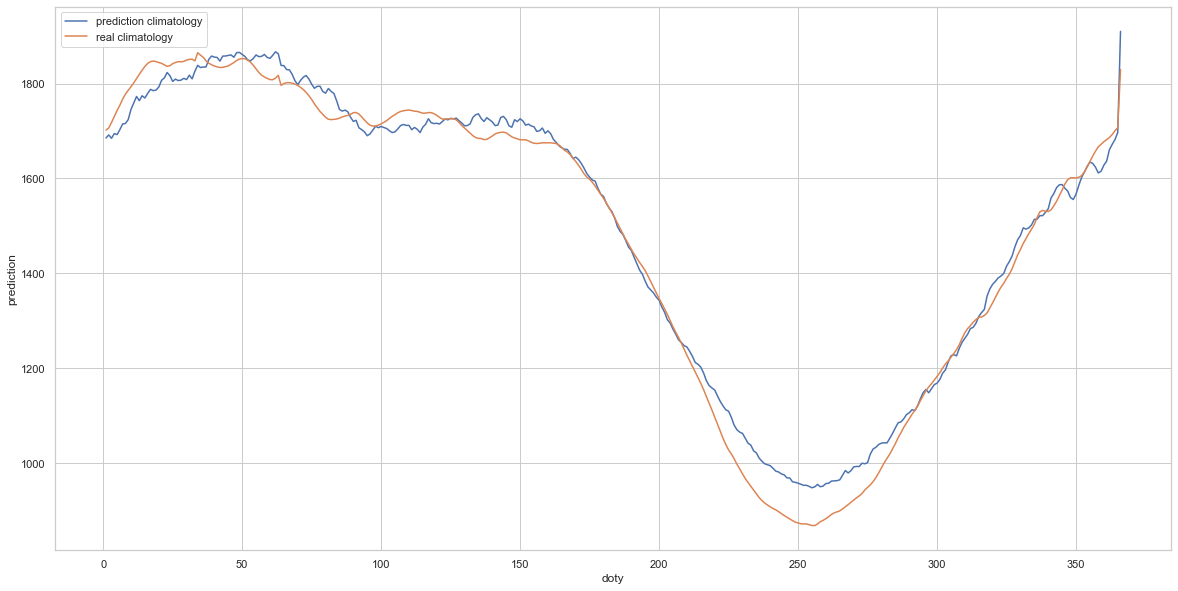

In [12]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [13]:
###overprediction for autumn/low

In [14]:
from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [15]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_FRK2_0042.joblib']